In [1]:
folder_name = '/home/yoyo/Desktop/SimCLR/runs/Jul05_23-00-54_yoyo'

In [2]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import classification_report
import importlib.util
import glob
from PIL import Image
from sklearn.metrics import confusion_matrix

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [4]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 256,
 'epochs': 200,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(128,128,3)',
  'num_workers': 0,
  'valid_size': 0.1},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [5]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs/Jul05_23-00-54_yoyo/checkpoints'

In [6]:
# args = {'dataset':'amazon'}
args = {'dataset':'oilpalm'}
args

{'dataset': 'oilpalm'}

In [7]:
def _load_data(prefix="train", img_size=128):
    img_list = glob.glob('../data/satellite/' + args['dataset'] + '/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f).convert('RGB').resize((img_size, img_size))
        X_train.append(img)
        img.load()
    X_train = np.stack(X_train).transpose(0,3,1,2)
    
    if args['dataset'] == 'amazon':
        tag = 'agri'
    else:
        tag = 'palm'
    y_train = np.array([f.split('/')[-2] == tag for f in img_list])
    
    print("===  {} dataset ===".format(args['dataset']))
    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train

In [8]:
# load facemask train data
X_train, y_train = _load_data("train")

# Xtrain1, ytrain1 = _load_data("train")
# Xtrain2, ytrain2 = _load_data("unlabeled")
# n = Xtrain2.shape[0]
# n_spl = int(n*1.0)
# X_train = np.concatenate((Xtrain1, Xtrain2[:n_spl]))
# y_train = np.concatenate((ytrain1, ytrain2[:n_spl]))

===  oilpalm dataset ===
train images
(187, 3, 128, 128)
(187,)


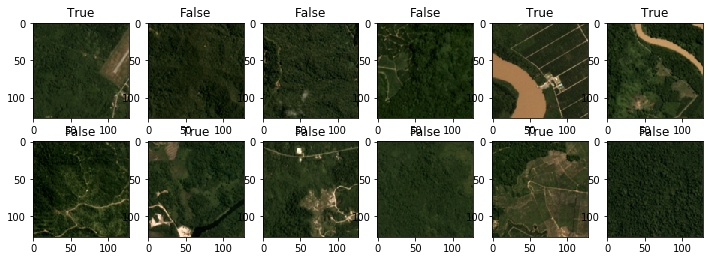

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i].transpose(1,2,0))
    ax.title.set_text(y_train[i])
plt.show()

In [10]:
# load facemask test data
X_test, y_test = _load_data("test")

===  oilpalm dataset ===
test images
(193, 3, 128, 128)
(193,)


## Test protocol #1 PCA features

In [11]:
# scaler = preprocessing.StandardScaler()
# scaler.fit(X_train.reshape((X_train.shape[0],-1)))

# pca = PCA(n_components=min(config['model']['out_dim'], X_train.shape[0]))

# X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
# X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

# print("PCA features")
# print(X_train_pca.shape)
# print(X_test_pca.shape)

In [12]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    if args['dataset'] == 'amazon':
        tag = 'agri'
    else:
        tag = 'palm'
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=10.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    predIdxs = clf.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, predIdxs, target_names=['no_'+tag, tag], digits=3))
    print(confusion_matrix(y_test, predIdxs))
    
    print("-------------------------------")
    svm = SVC(random_state=0)
    svm.fit(X_train, y_train)
    print("SVM feature eval")
    print("Train score:", svm.score(X_train, y_train))
    print("Test score:", svm.score(X_test, y_test))
    predIdxs = svm.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, predIdxs, target_names=['no_'+tag, tag], digits=3))
    print(confusion_matrix(y_test, predIdxs))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))
    predIdxs = neigh.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, predIdxs, target_names=['no_'+tag, tag], digits=3))
    print(confusion_matrix(y_test, predIdxs))

In [13]:
# linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

# ## clean up resources
# del X_train_pca
# del X_test_pca

## Protocol #2 Logisitc Regression

In [14]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [15]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [16]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [17]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(187, 512)


In [18]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy().reshape((-1,512)))
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(193, 512)


In [19]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

Logistic Regression feature eval
Train score: 1.0
Test score: 0.6269430051813472
              precision    recall  f1-score   support

     no_palm      0.649     0.610     0.629       100
        palm      0.606     0.645     0.625        93

    accuracy                          0.627       193
   macro avg      0.627     0.628     0.627       193
weighted avg      0.628     0.627     0.627       193

[[61 39]
 [33 60]]
-------------------------------
SVM feature eval
Train score: 0.8288770053475936
Test score: 0.7253886010362695
              precision    recall  f1-score   support

     no_palm      0.764     0.680     0.720       100
        palm      0.692     0.774     0.731        93

    accuracy                          0.725       193
   macro avg      0.728     0.727     0.725       193
weighted avg      0.729     0.725     0.725       193

[[68 32]
 [21 72]]
-------------------------------
KNN feature eval
Train score: 0.7112299465240641
Test score: 0.6839378238341969
   

## Amazon

Logistic Regression feature eval
Train score: 0.9981042654028436
Test score: 0.7916666666666666
              precision    recall  f1-score   support

     no_agri      0.802     0.808     0.805       563
        agri      0.779     0.773     0.776       493

    accuracy                          0.792      1056
   macro avg      0.791     0.790     0.791      1056
weighted avg      0.792     0.792     0.792      1056

[[455 108]
 [112 381]]
-------------------------------
SVM feature eval
Train score: 0.8928909952606635
Test score: 0.84375
              precision    recall  f1-score   support

     no_agri      0.867     0.835     0.851       563
        agri      0.819     0.854     0.836       493

    accuracy                          0.844      1056
   macro avg      0.843     0.844     0.843      1056
weighted avg      0.845     0.844     0.844      1056

[[470  93]
 [ 72 421]]
-------------------------------
KNN feature eval
Train score: 0.861611374407583
Test score: 0.8304924242424242
              precision    recall  f1-score   support

     no_agri      0.854     0.822     0.838       563
        agri      0.805     0.840     0.822       493

    accuracy                          0.830      1056
   macro avg      0.830     0.831     0.830      1056
weighted avg      0.831     0.830     0.831      1056

[[463 100]
 [ 79 414]]

## Oil Palm

200 Iter Lr 3e-4

Logistic Regression feature eval
Train score: 1.0
Test score: 0.6476683937823834
              precision    recall  f1-score   support

     no_palm      0.663     0.650     0.657       100
        palm      0.632     0.645     0.638        93

    accuracy                          0.648       193
   macro avg      0.647     0.648     0.647       193
weighted avg      0.648     0.648     0.648       193

[[65 35]
 [33 60]]
-------------------------------
SVM feature eval
Train score: 0.786096256684492
Test score: 0.7305699481865285
              precision    recall  f1-score   support

     no_palm      0.688     0.880     0.772       100
        palm      0.815     0.570     0.671        93

    accuracy                          0.731       193
   macro avg      0.751     0.725     0.721       193
weighted avg      0.749     0.731     0.723       193

[[88 12]
 [40 53]]
-------------------------------
KNN feature eval
Train score: 0.7379679144385026
Test score: 0.7098445595854922
              precision    recall  f1-score   support

     no_palm      0.662     0.900     0.763       100
        palm      0.825     0.505     0.627        93

    accuracy                          0.710       193
   macro avg      0.743     0.703     0.695       193
weighted avg      0.740     0.710     0.697       193

[[90 10]
 [46 47]]

200 Iter Lr 1e-4

Logistic Regression feature eval
Train score: 1.0
Test score: 0.5751295336787565
              precision    recall  f1-score   support

     no_palm      0.583     0.630     0.606       100
        palm      0.565     0.516     0.539        93

    accuracy                          0.575       193
   macro avg      0.574     0.573     0.573       193
weighted avg      0.574     0.575     0.574       193

[[63 37]
 [45 48]]
-------------------------------
SVM feature eval
Train score: 0.7593582887700535
Test score: 0.7409326424870466
              precision    recall  f1-score   support

     no_palm      0.719     0.820     0.766       100
        palm      0.772     0.656     0.709        93

    accuracy                          0.741       193
   macro avg      0.746     0.738     0.738       193
weighted avg      0.745     0.741     0.739       193

[[82 18]
 [32 61]]
-------------------------------
KNN feature eval
Train score: 0.7058823529411765
Test score: 0.7046632124352331
              precision    recall  f1-score   support

     no_palm      0.684     0.800     0.737       100
        palm      0.737     0.602     0.663        93

    accuracy                          0.705       193
   macro avg      0.710     0.701     0.700       193
weighted avg      0.709     0.705     0.701       193

[[80 20]
 [37 56]]